In [1]:
# import external libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

#Local PY files
from cleaning_functions import *
from eda import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *


# Configure matplotlib for jupyter.
%matplotlib inline

/home/corey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Imports the dataframes
dffo = pd.read_csv("data/submission_format.csv")
dftr = pd.read_csv("data/training_set_features.csv")
dfte = pd.read_csv("data/test_set_features.csv")
dfla = pd.read_csv("data/training_set_labels.csv")

df = pd.merge(dftr, dfla, on="respondent_id")
df = df.set_index("respondent_id")

In [3]:
#Cleaning steps to do before column names are established.
df = initial_cleaning(df)

#Lists of columns to be fed into the model processor object and the functions that
#manage imputed values for the nans.
binary_columns = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'homeowner']
ordinal_columns = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
continuous_columns = ["household_adults", "household_children"]

#Function to generate a dictionary that manages impute strategies depending on
#the type of data.
impute_dict = gen_impute_dict(binary_columns, ordinal_columns, continuous_columns)

#Cleans the rest of the data and stores the fitted imputer objects into a list for later use.
df, imputes = fit_clean_data(df, impute_dict)

In [6]:
df.to_pickle("data.pickle")

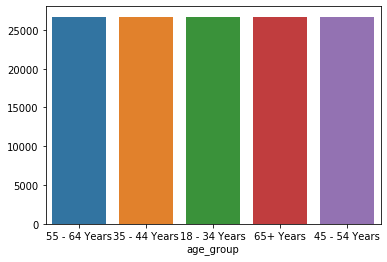

In [5]:
sns.barplot(x=df["age_group"], y=df["age_group"].count())

In [9]:
(df['missing_doctor_recc_h1n1'] == df['missing_doctor_recc_h1n1']).sum()

26707

In [25]:
df["missing_opinion"] = df["missing_opinion"] == 0

In [36]:
def trimmed_heatmap(df, columns, font_scale=1, annot=True, figsize=(15,10)):
    plt.figure(figsize=figsize)
    corr = df[columns].corr()
    sns.set(style="dark")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']

    x=corr['x']
    y=corr['y']
    size=corr['value'].abs()
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(23, 229, s=84, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation
    color = corr["value"]
    
    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]
    
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square colors, mapped to color palette
        marker='s' # Use square as scatterplot marker
    )
    
     # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 
    plt.show()
    return mask

<Figure size 1440x1080 with 0 Axes>

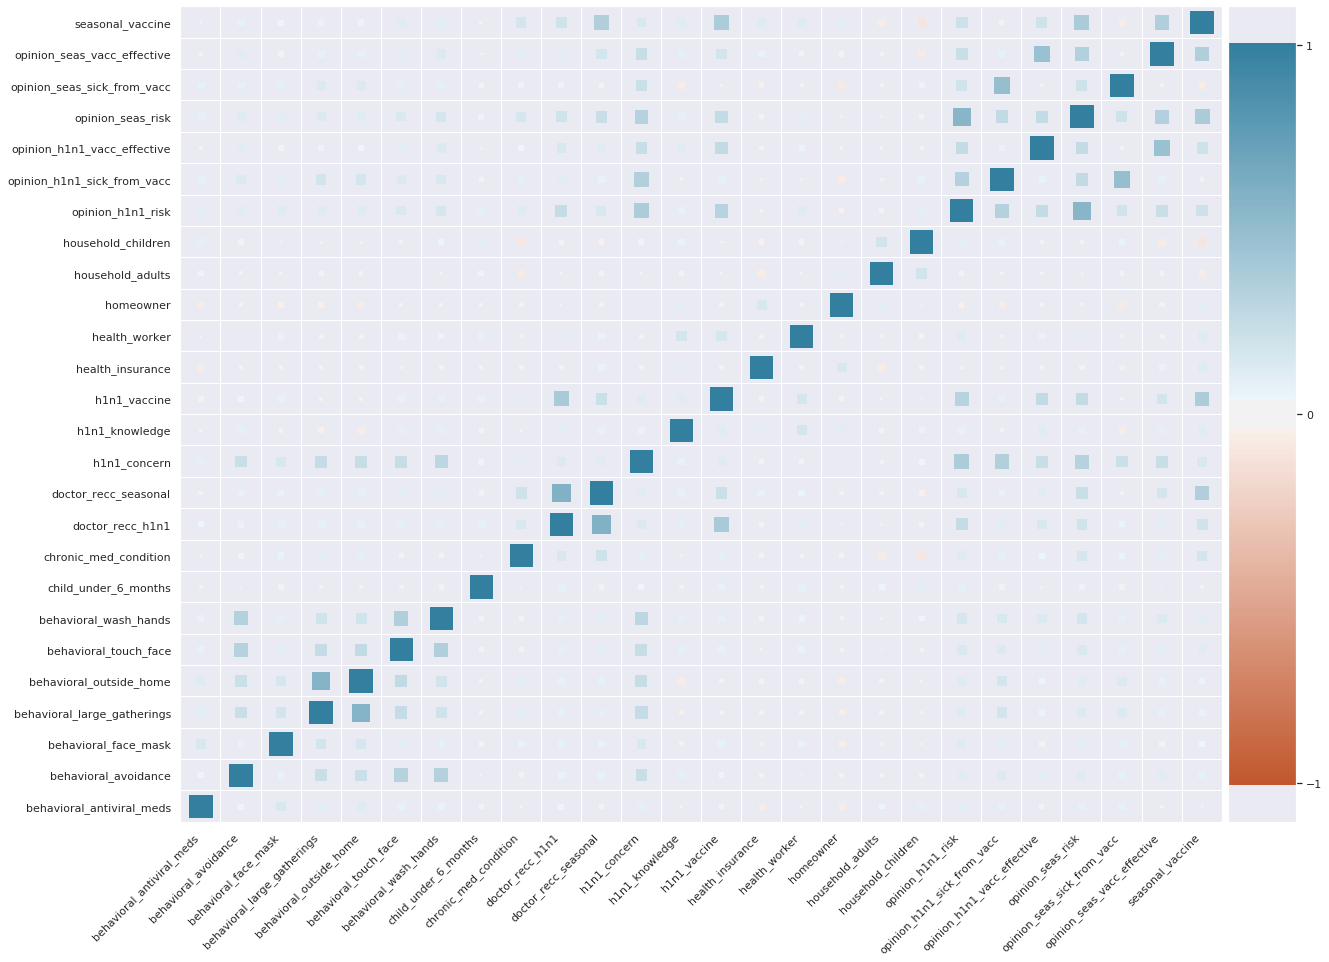

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

In [37]:
trimmed_heatmap(df, df.columns.drop(missing_dummies), font_scale=.4, figsize=(20,15))

In [46]:
sns.pairplot(df[['column','column','column','column']],hue = 'column')

KeyError: "None of [Index(['column', 'column', 'column', 'column'], dtype='object')] are in the [columns]"

In [30]:
pal = sns.color_palette(("#102ca8", "#ee823e"))

In [26]:
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'missing_behavioral_antiviral_meds', 'missing_behavioral_avoidance',
       'missing_behavioral_face_mask', 'missing_behavior

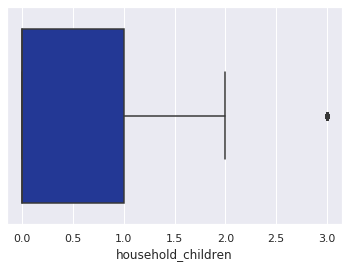

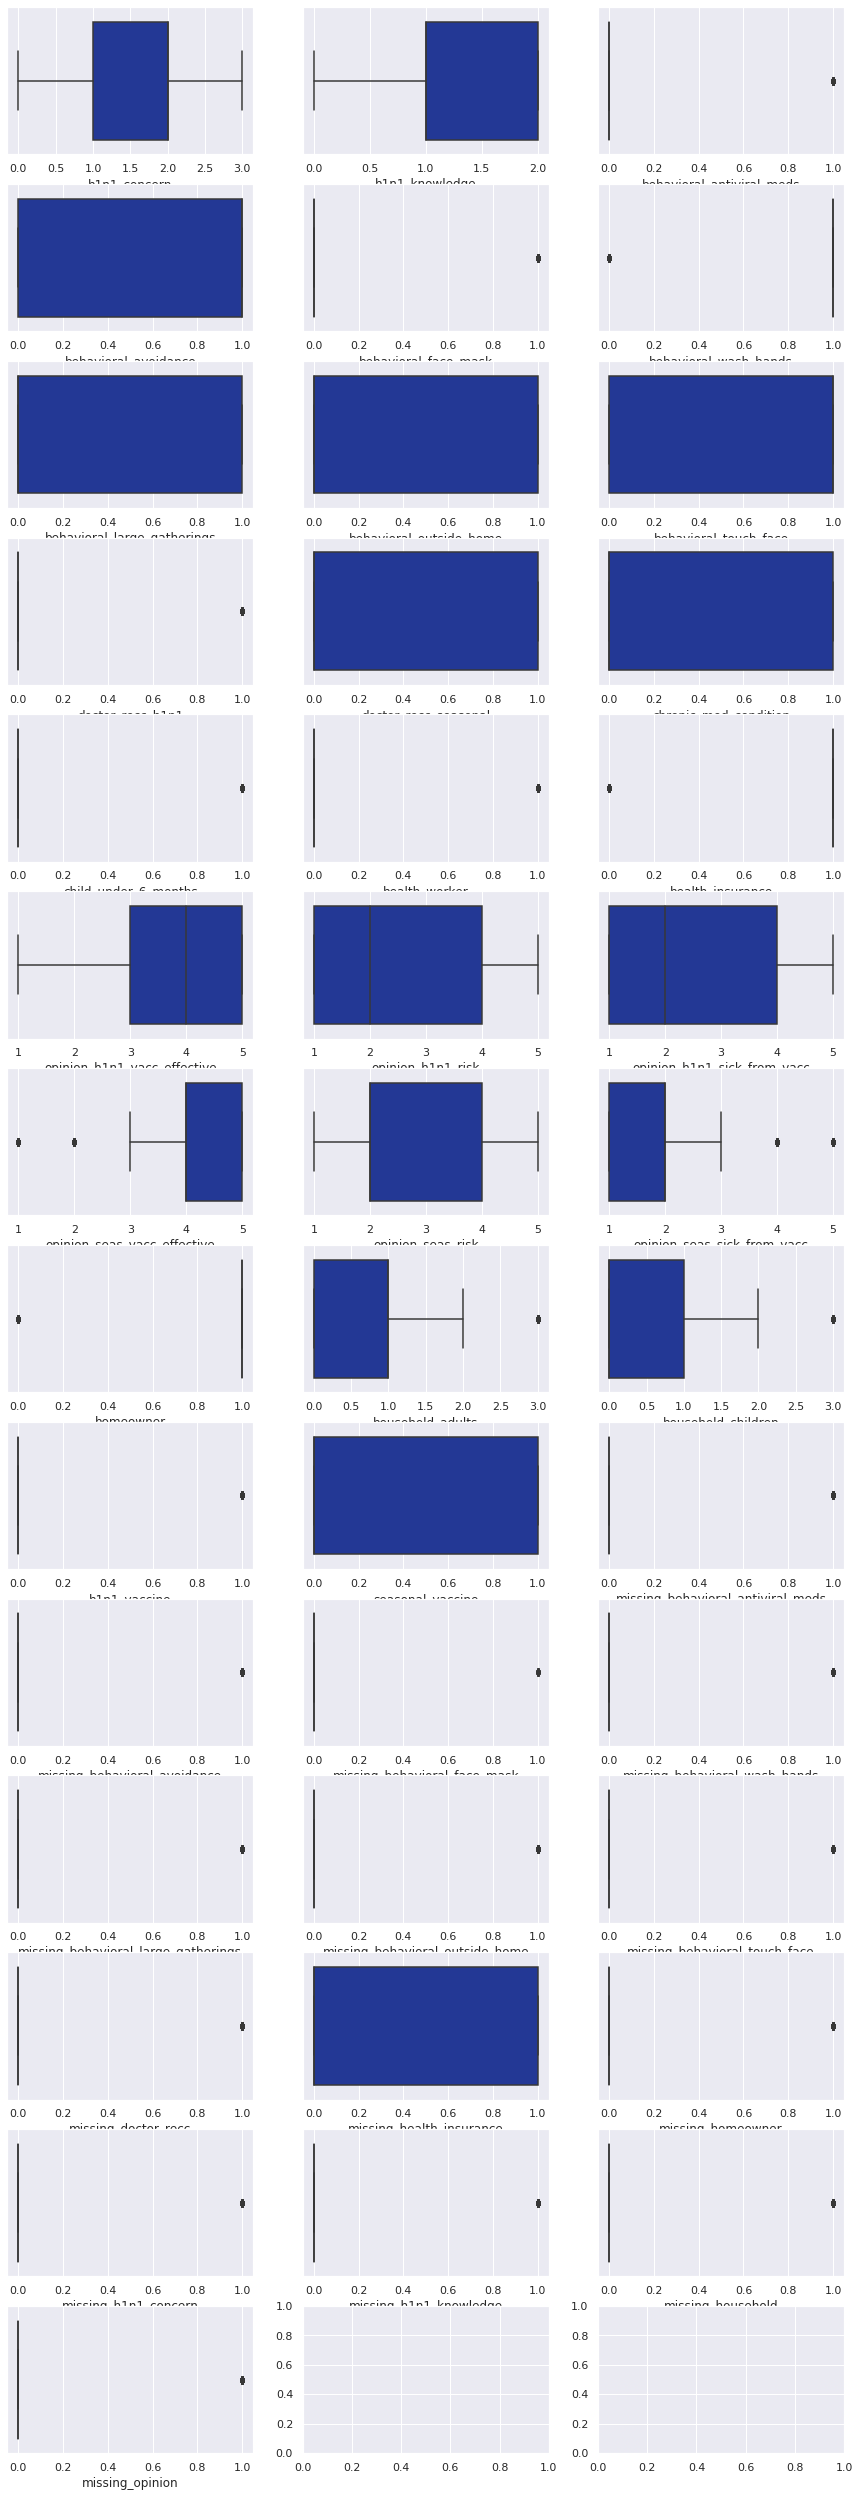

In [32]:
kwargs = {"palette": pal}
graph = Multiplot(df[df.columns.drop(nom.drop(ordinal_columns))], 3, (15,45))
graph.sb_multiplot(sns.boxplot, kwargs)

In [11]:
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'missing_behavioral_antiviral_meds', 'missing_behavioral_avoidance',
       'missing_behavioral_face_mask', 'missing_behavior

KeyboardInterrupt: 

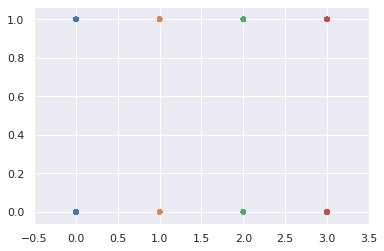

In [66]:
sns.swarmplot(x="household_adults", y='seasonal_vaccine', data=df)

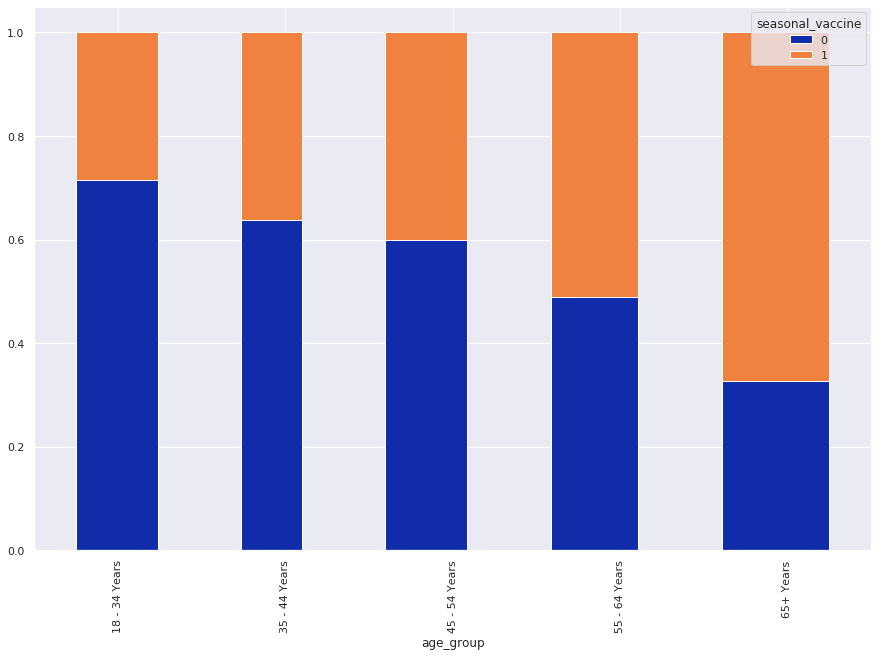

In [38]:
plot_stacked_proportion(df, 'age_group', 'seasonal_vaccine', palette=pal)

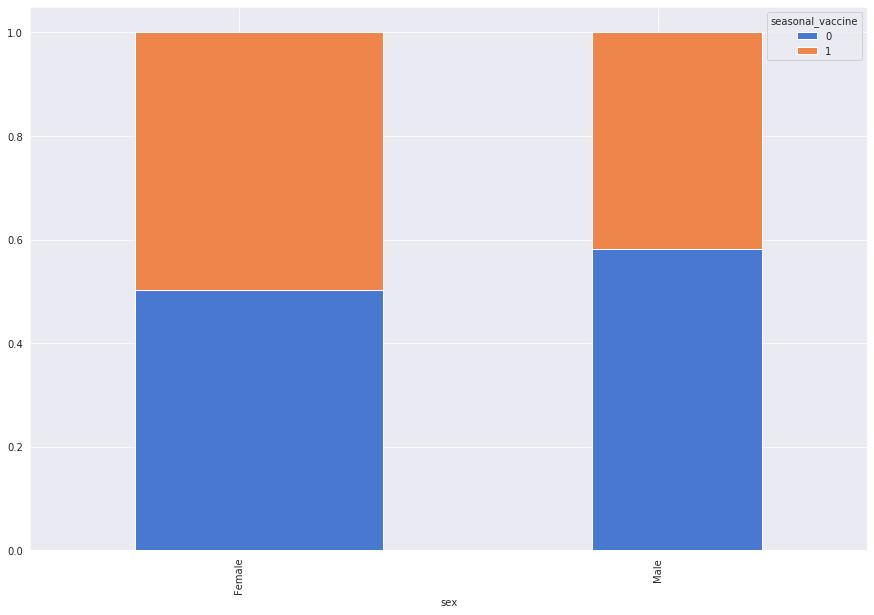

In [24]:
plot_stacked_proportion(df, 'sex', 'seasonal_vaccine')

In [ ]:
df = get_imputer_objs(df, impute_dict, imputes)

In [36]:
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'missing_behavioral_antiviral_meds', 'missing_behavioral_avoidance',
       'missing_behavioral_face_mask', 'missing_behavior

In [8]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.

missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"
target_cols = [target_col1, target_col2]
untr = ['household_adults', 'household_children',]
nom = df.columns.drop([*untr, *binary_columns, *target_cols, *missing_dummies])
# nom = df.columns.drop(pd.Index([*untr, *target_cols])).to_numpy().tolist()
# polyc = [*nom, *pay_dummies, "PAY_0"]
#The dicts that come into the arguments.

categorical = {
    "nominal_features":nom, "standard_dummies": binary_columns, "impute_dummies":missing_dummies
}

continuous = {"untransformed":untr}
polynomial = {"method":"eliminate", "columns":[*missing_dummies, *nom.drop(
    ['age_group', 'education', 'sex'])]}

In [37]:
data = DataPreprocessor(df, target_col1, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type=False, poly_degree=None)
data.get_df()

Creating Dummies
Skipping polynomial features
Skipping class imbalance functions
No scaling specified
Skipping scaling


,household_adults,household_children,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,h1n1_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
358,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
20097,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
24982,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
12299,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
8759,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10407,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,1
7443,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
16022,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [42]:
data.X_train[data.cols_dummies]

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
358,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
20097,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
24982,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
12299,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8759,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9154,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24711,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
14353,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [26]:
full_value_counts(df, "h1n1_vaccine")

There are 2 unique values with 0 nan values making up 0.0%
21033-0 --78.75%
5674-1 --21.25%


In [49]:
data = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type="standard", poly_degree=2)
data.get_df()

Creating Dummies
Getting polynomial features of degree 2
Skipping class imbalance functions
Using standard scaler


,household_adults,household_children,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,education_College Graduate education_Some College,education_College Graduate education_unknown,education_College Graduate sex_Male,education_Some College^2,education_Some College education_unknown,education_Some College sex_Male,education_unknown^2,education_unknown sex_Male,sex_Male^2,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
358,0.151034,2.684344,-0.225289,-1.634308,-0.272716,-2.175076,-0.745177,-0.710112,0.685345,-0.505114,...,0.0,0.0,-0.440275,-0.598381,0.0,-0.329201,-0.235760,-0.156065,-0.828332,0
20097,0.151034,-0.571215,-0.225289,-1.634308,-0.272716,0.459754,-0.745177,-0.710112,-1.459119,-0.505114,...,0.0,0.0,-0.440275,-0.598381,0.0,-0.329201,-0.235760,-0.156065,-0.828332,0
24982,0.151034,-0.571215,-0.225289,0.611880,-0.272716,0.459754,-0.745177,1.408228,0.685345,1.979750,...,0.0,0.0,-0.440275,1.671176,0.0,3.037661,-0.235760,-0.156065,1.207246,1
12299,0.151034,-0.571215,4.438752,0.611880,-0.272716,0.459754,-0.745177,-0.710112,0.685345,1.979750,...,0.0,0.0,-0.440275,1.671176,0.0,-0.329201,-0.235760,-0.156065,-0.828332,1
8759,-1.184580,-0.571215,-0.225289,-1.634308,-0.272716,0.459754,1.341963,1.408228,0.685345,1.979750,...,0.0,0.0,-0.440275,-0.598381,0.0,-0.329201,-0.235760,-0.156065,-0.828332,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10407,-1.184580,0.513971,4.438752,0.611880,-0.272716,0.459754,-0.745177,-0.710112,0.685345,1.979750,...,0.0,0.0,-0.440275,-0.598381,0.0,-0.329201,4.241593,-0.156065,-0.828332,1
7443,0.151034,-0.571215,-0.225289,-1.634308,-0.272716,0.459754,-0.745177,-0.710112,0.685345,1.979750,...,0.0,0.0,-0.440275,1.671176,0.0,-0.329201,-0.235760,-0.156065,-0.828332,1
16022,0.151034,-0.571215,-0.225289,0.611880,-0.272716,0.459754,1.341963,1.408228,0.685345,-0.505114,...,0.0,0.0,-0.440275,-0.598381,0.0,-0.329201,-0.235760,-0.156065,-0.828332,1


In [50]:
forest = RandomForestClassifier(criterion='gini', max_features="auto",
                                random_state=data.random_state, n_jobs=-1,
                                max_depth=9,
                               n_estimators=500)
forest.fit(data.get_X_train(), data.y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=124, verbose=0,
                       warm_start=False)

In [48]:
evaluate_model(forest, data.get_X_test(), data.y_test)

F1 Score: 0.717741935483871
Accuracy: 0.7510295769374766
Precision: 0.7532293986636971
Recall: 0.6854479124442643
Params:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 124, 'verbose': 0, 'warm_start': False}


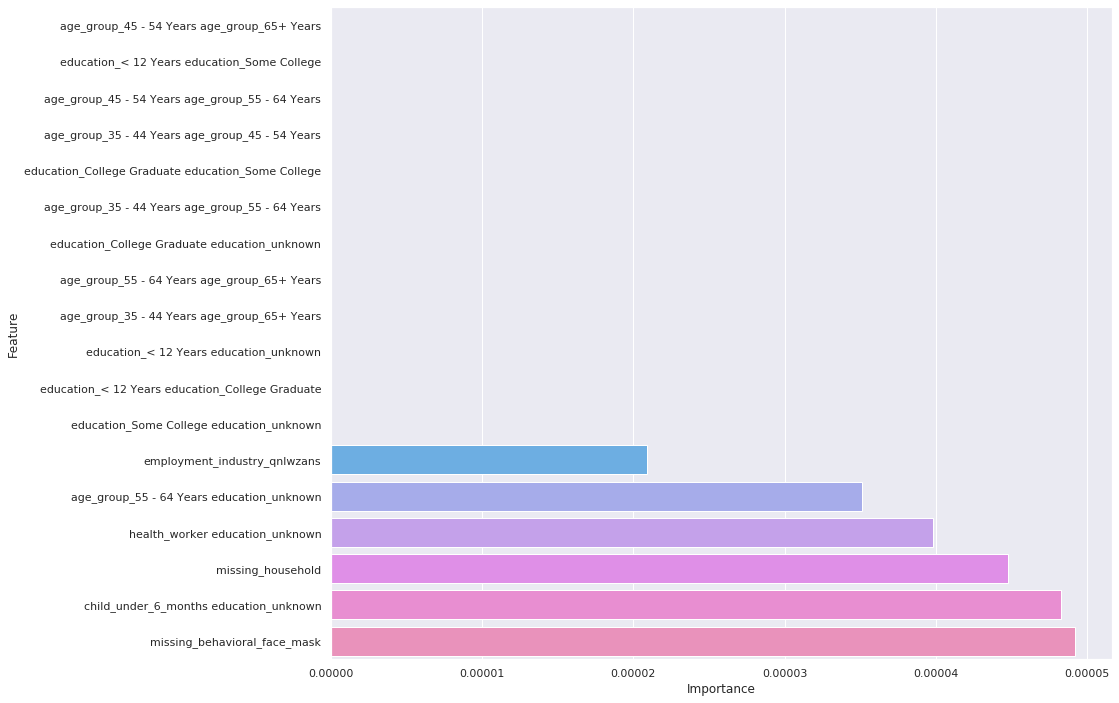

In [56]:
show_feature_importances(forest, data.get_X_test(), figsize=(14, 12), font_scale=1, ascending=True, rows=18)

In [4]:
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'missing_doctor_recc', 'missing_health_insurance', 'missing_homeowner',
       'missing_household', 'missing_opinion'],
     

In [11]:
chi_squared_loop(df, 'seasonal_vaccine', .01)

seasonal_vaccine     0     1
h1n1_concern                
0.0               2254  1042
1.0               4811  3342
2.0               5185  5482
3.0               2022  2569
seasonal_vaccine     0     1
h1n1_knowledge              
0.0               1588   918
1.0               8350  6364
2.0               4334  5153
seasonal_vaccine               0      1
behavioral_antiviral_meds              
0.0                        13594  11812
1.0                          678    623
seasonal_vaccine         0     1
behavioral_avoidance            
0.0                   4337  2934
1.0                   9935  9501
seasonal_vaccine          0      1
behavioral_face_mask              
0.0                   13457  11409
1.0                     815   1026
seasonal_vaccine           0      1
behavioral_wash_hands              
0.0                     3052   1598
1.0                    11220  10837
seasonal_vaccine                0     1
behavioral_large_gatherings            
0.0                      

[['behavioral_antiviral_meds', 0.34000896763675553],
 ['child_under_6_months', 0.029922400624159774]]

In [12]:
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'missing_doctor_recc', 'missing_health_insurance', 'missing_homeowner',
       'missing_household', 'missing_opinion'],
     

In [21]:
target = 'h1n1_vaccine'
column = 'opinion_seas_sick_from_vacc'

seasonal_vaccine,0,1
opinion_seas_sick_from_vacc,,
1.0,5782,6088
2.0,4732,3438
3.0,77,17
4.0,2622,2230
5.0,1059,662


In [23]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
(count, nobs, value=None, alternative='two-sided', prop_var=False)[

In [89]:
import math

    
calc_z_from_proportions(v1, v2, n1, n2)

3.5521777762604283

In [9]:
df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'homeowner', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine',
       'missing_doctor_recc', 'missing_health_insurance', 'missing_homeowner',
       'missing_household', 'missing_opinion'],
     

In [22]:
calc_chi_squared(df, 'household_children', target)

h1n1_vaccine            0     1
household_children             
0.0                 14899  4022
1.0                  2501   674
2.0                  2235   629
3.0                  1398   349


(2.561284667933834,
 0.4643173046901464,
 3,
 array([[14901.16422661,  4019.83577339],
        [ 2500.45961733,   674.54038267],
        [ 2255.53270678,   608.46729322],
        [ 1375.84344928,   371.15655072]]))

In [23]:
z_test_proportions(df, 'household_children', target, 1, .995)

([],
 [[0.0, 22.74315857248602, 1.677139902707958e-114],
  [1.0, 176.181923313667, 0.0],
  [2.0, 190.60763107625579, 0.0],
  [3.0, 281.3672113384996, 0.0]])

In [88]:
n1 = table.sum(axis=1)[1]
n2 = table.sum().sum()-n1
v1 = table[1][1]
v2 = table[1].sum() - v1
z_test_proportions(v1,v2,n1,n2)
z_test_proportions(10,20,100,100)

nan